# Batch Size vs Performance Analysis

This notebook analyzes how batch size affects training performance, showing execution time with variability and detailed statistics.


## Setup and Data Loading


In [3]:
import json
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Configuration
LOG_DIR = 'performance_logs'  # Change this to your performance logs directory
OUTPUT_DIR = 'plots'  # Directory to save plots (optional)


In [4]:
def load_performance_logs(log_dir):
    """Load all performance log JSON files from a directory."""
    log_dir = Path(log_dir)
    if not log_dir.exists():
        raise FileNotFoundError(f"Log directory not found: {log_dir}")
    
    logs = []
    json_files = list(log_dir.glob("*_performance.json"))
    
    if len(json_files) == 0:
        raise ValueError(f"No performance log JSON files found in {log_dir}")
    
    print(f"Found {len(json_files)} performance log files")
    
    for json_file in json_files:
        try:
            with open(json_file, 'r') as f:
                log_data = json.load(f)
                logs.append(log_data)
        except Exception as e:
            print(f"Warning: Failed to load {json_file}: {e}")
            continue
    
    print(f"Successfully loaded {len(logs)} performance logs")
    return logs

# Load the logs
logs = load_performance_logs(LOG_DIR)


Found 21 performance log files
Successfully loaded 21 performance logs


In [5]:
# Create DataFrame
df_data = []
for log in logs:
    if 'batch_size' not in log:
        continue
    df_data.append({
        'batch_size': log['batch_size'],
        'execution_time_seconds': log.get('training_duration_seconds', 0),
        'execution_time_minutes': log.get('training_duration_seconds', 0) / 60,
        'throughput': log.get('throughput_images_per_second', 0),
        'train_accuracy': log.get('final_train_accuracy', 0),
        'val_accuracy': log.get('final_val_accuracy', 0),
        'train_loss': log.get('final_train_loss', 0),
        'val_loss': log.get('final_val_loss', 0),
    })

df = pd.DataFrame(df_data)
print(f"\nTotal runs: {len(df)}")
print(f"Unique batch sizes: {sorted(df['batch_size'].unique())}")
print(f"\nRuns per batch size:")
print(df['batch_size'].value_counts().sort_index())



Total runs: 21
Unique batch sizes: [np.int64(64), np.int64(128), np.int64(256), np.int64(512)]

Runs per batch size:
batch_size
64     5
128    5
256    5
512    6
Name: count, dtype: int64


## 1. Batch Size vs Execution Time (with Variability)


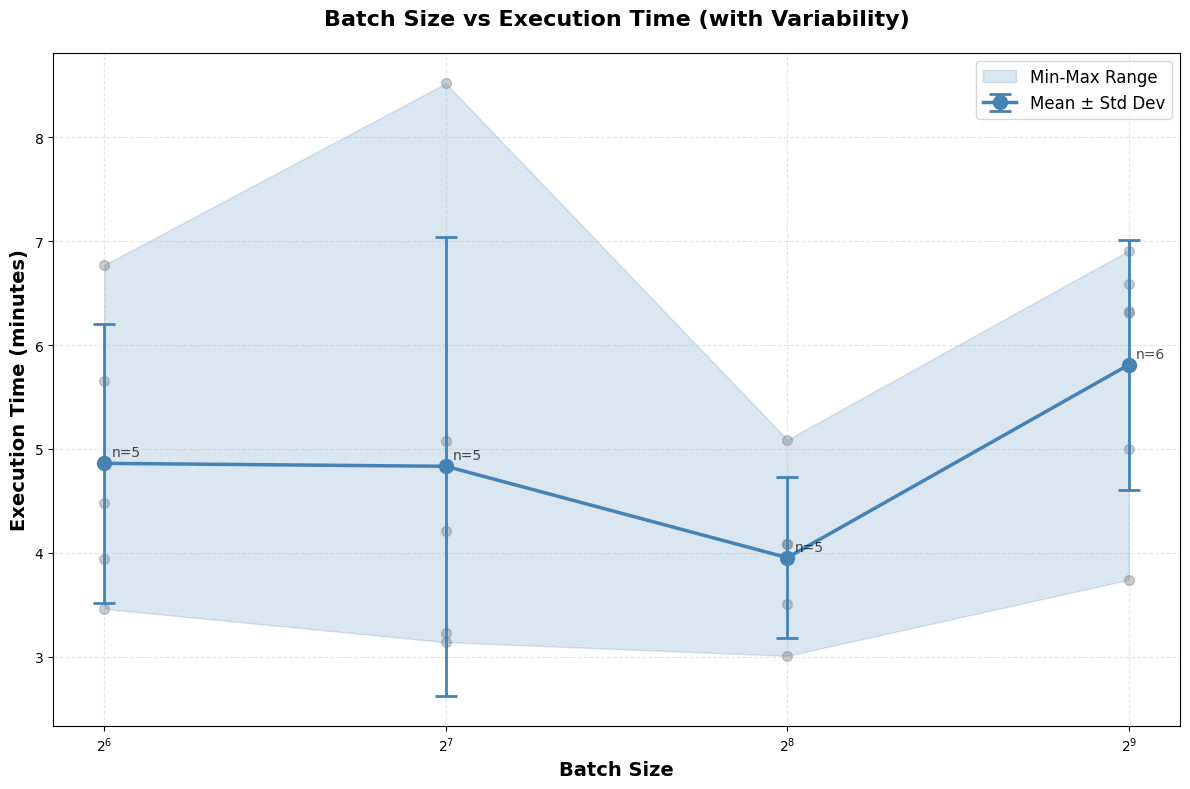


✓ Saved plot to: plots/batch_size_vs_execution_time.png


<Figure size 640x480 with 0 Axes>

In [6]:
# Group by batch size and calculate statistics for execution time
exec_time_stats = df.groupby('batch_size')['execution_time_minutes'].agg([
    'count', 'mean', 'std', 'min', 'max'
]).reset_index()
exec_time_stats.columns = ['batch_size', 'count', 'mean', 'std', 'min', 'max']
exec_time_stats = exec_time_stats.sort_values('batch_size')

# Create figure with error bars and confidence intervals
fig, ax = plt.subplots(figsize=(12, 8))

batch_sizes = exec_time_stats['batch_size'].values
means = exec_time_stats['mean'].values
stds = exec_time_stats['std'].values

# Plot with error bars (showing standard deviation)
ax.errorbar(batch_sizes, means, yerr=stds, 
            fmt='o-', linewidth=2.5, markersize=10, 
            color='steelblue', capsize=8, capthick=2,
            label='Mean ± Std Dev', elinewidth=2)

# Add shaded area showing min-max range
mins = exec_time_stats['min'].values
maxs = exec_time_stats['max'].values
ax.fill_between(batch_sizes, mins, maxs, 
                alpha=0.2, color='steelblue', 
                label='Min-Max Range')

# Plot individual points for each run (if multiple runs)
for bs in batch_sizes:
    subset = df[df['batch_size'] == bs]
    if len(subset) > 1:
        ax.scatter([bs] * len(subset), subset['execution_time_minutes'].values,
                  alpha=0.4, s=50, color='gray', zorder=0)

ax.set_xlabel('Batch Size', fontsize=14, fontweight='bold')
ax.set_ylabel('Execution Time (minutes)', fontsize=14, fontweight='bold')
ax.set_title('Batch Size vs Execution Time (with Variability)', 
             fontsize=16, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xscale('log', base=2)
ax.legend(fontsize=12, loc='best')

# Add annotations showing count of runs
for idx, row in exec_time_stats.iterrows():
    if row['count'] > 1:
        ax.annotate(f"n={int(row['count'])}", 
                   xy=(row['batch_size'], row['mean']),
                   xytext=(5, 5), textcoords='offset points',
                   fontsize=10, alpha=0.7)

plt.tight_layout()
plt.show()

# Save if output directory specified
if OUTPUT_DIR:
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    plt.savefig(os.path.join(OUTPUT_DIR, 'batch_size_vs_execution_time.png'), 
                dpi=300, bbox_inches='tight')
    print(f"\n✓ Saved plot to: {os.path.join(OUTPUT_DIR, 'batch_size_vs_execution_time.png')}")


In [7]:
# Calculate statistics grouped by batch size (mean and std only)
numeric_cols = ['execution_time_minutes', 'throughput', 
                'train_accuracy', 'val_accuracy', 
                'train_loss', 'val_loss']

# Group by batch size and calculate statistics (only mean and std)
stats = df.groupby('batch_size')[numeric_cols].agg([
    'mean', 'std'
]).round(4)

# Flatten column names and rename for clarity
stats.columns = ['_'.join(col).strip() for col in stats.columns.values]
stats = stats.sort_index()

# Rename columns to be more readable
new_columns = {}
for col in stats.columns:
    if col.endswith('_mean'):
        metric = col.replace('_mean', '')
        new_columns[col] = f'{metric} (mean)'
    elif col.endswith('_std'):
        metric = col.replace('_std', '')
        new_columns[col] = f'{metric} (std)'
stats = stats.rename(columns=new_columns)

# Display the statistics table
print("="*100)
print("Statistics Grouped by Batch Size (Mean and Std Dev)")
print("="*100)
display(stats)
print("="*100)


Statistics Grouped by Batch Size (Mean and Std Dev)


,execution_time_minutes (mean),execution_time_minutes (std),throughput (mean),throughput (std),train_accuracy (mean),train_accuracy (std),val_accuracy (mean),val_accuracy (std),train_loss (mean),train_loss (std),val_loss (mean),val_loss (std)
batch_size,,,,,,,,,,,,
64,4.8613,1.3467,3341.3725,874.0179,0.6558,0.0000,0.6469,0.0,0.6441,0.0001,0.6497,0.0003
128,4.8330,2.2079,3617.0724,1278.2450,0.6558,0.0000,0.6469,0.0,0.6440,0.0001,0.6528,0.0093
256,3.9530,0.7777,3995.8223,780.3710,0.6558,0.0000,0.6469,0.0,0.6440,0.0001,0.6495,0.0002
512,5.8108,1.2063,2759.0307,719.1672,0.6558,0.0001,0.6469,0.0,0.6462,0.0022,0.6559,0.0058


In [8]:
# Create a formatted table focusing on execution time (mean and std only)
exec_time_table = df.groupby('batch_size')['execution_time_minutes'].agg([
    ('mean', 'mean'),
    ('std', 'std'),
]).round(4)

exec_time_table.columns = ['Mean (minutes)', 'Std Dev (minutes)']

print("\n" + "="*80)
print("Execution Time Statistics by Batch Size")
print("="*80)
display(exec_time_table)
print("="*80)



Execution Time Statistics by Batch Size


,Mean (minutes),Std Dev (minutes)
batch_size,,
64,4.8613,1.3467
128,4.8330,2.2079
256,3.9530,0.7777
512,5.8108,1.2063


## Export Statistics to CSV


In [9]:
if OUTPUT_DIR:
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    # Save full statistics
    stats_csv_path = os.path.join(OUTPUT_DIR, 'batch_size_statistics.csv')
    stats.to_csv(stats_csv_path)
    print(f"✓ Saved full statistics to: {stats_csv_path}")
    
    # Save execution time table
    exec_time_csv_path = os.path.join(OUTPUT_DIR, 'execution_time_statistics.csv')
    exec_time_table.to_csv(exec_time_csv_path)
    print(f"✓ Saved execution time statistics to: {exec_time_csv_path}")
else:
    print("Set OUTPUT_DIR to save CSV files")


✓ Saved full statistics to: plots/batch_size_statistics.csv
✓ Saved execution time statistics to: plots/execution_time_statistics.csv
